Import all essential libraries for data manipulation, visualization, and scientific computing. This includes pandas and numpy for data handling, matplotlib and seaborn for plotting, and scipy for advanced statistical operations. These libraries form the backbone of the supervised learning workflow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

Load the preprocessed diabetes dataset from CSV into a pandas DataFrame. This dataset has already undergone cleaning and feature engineering, making it ready for supervised machine learning tasks.

In [2]:
df = pd.read_csv('processed_diabetes_data.csv')

Convert the 'age' column to integer, map age categories to their mid-point values, and display the distribution before and after mapping. This transformation makes the age feature more interpretable and suitable for modeling.

In [3]:
df['age'] = df['age'].astype('int64')
print(df['age'].value_counts())
# convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df['age'].value_counts())

age
8     17331
7     15226
6     11903
9     10930
5      6494
4      2519
10     1749
3      1004
2       357
1        63
Name: count, dtype: int64
age
75    17331
65    15226
55    11903
85    10930
45     6494
35     2519
95     1749
25     1004
15      357
5        63
Name: count, dtype: int64


Define lists of nominal (categorical) features and medication columns, then convert these columns to object type for proper encoding. This step ensures that categorical variables are correctly handled during one-hot encoding and model training.

In [4]:
nominal_features = [
    "encounter_id",
    "patient_nbr",
    "gender",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "A1Cresult",
    # "age",
    "max_glu_serum",
    "diag_1",
    "diag_2",
    "diag_3",
    "hba1c_attention"
]

med_columns = [
        col
        for col in df.columns
        if col
        in [
            "metformin",
            "repaglinide",
            "nateglinide",
            "chlorpropamide",
            "glimepiride",
            "acetohexamide",
            "glipizide",
            "glyburide",
            "tolbutamide",
            "pioglitazone",
            "rosiglitazone",
            "acarbose",
            "miglitol",
            "troglitazone",
            "tolazamide",
            "examide",
            "citoglipton",
            "insulin",
            "glyburide-metformin",
            "glipizide-metformin",
            "glimepiride-pioglitazone",
            "metformin-rosiglitazone",
            "metformin-pioglitazone",
            "change",
            "diabetesMed",
        ]
    ]

nominal_features.extend(med_columns)

for col in nominal_features:
        if col in df.columns:
            df[col] = df[col].astype("object")

Display DataFrame information to inspect data types and non-null counts after preprocessing steps. This helps verify that all features are correctly formatted and that there are no unexpected missing values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67576 entries, 0 to 67575
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              67576 non-null  object
 1   patient_nbr               67576 non-null  object
 2   race                      67576 non-null  object
 3   gender                    67576 non-null  object
 4   age                       67576 non-null  int64 
 5   admission_type_id         67576 non-null  object
 6   discharge_disposition_id  67576 non-null  object
 7   admission_source_id       67576 non-null  object
 8   time_in_hospital          67576 non-null  int64 
 9   num_lab_procedures        67576 non-null  int64 
 10  num_procedures            67576 non-null  int64 
 11  num_medications           67576 non-null  int64 
 12  number_outpatient         67576 non-null  int64 
 13  number_emergency          67576 non-null  int64 
 14  number_inpatient      

Standardize all numeric columns and remove outliers using Z-score. Standardization ensures that all features contribute equally to model training, while outlier removal improves model robustness.

In [6]:
numerics = list(set(list(df._get_numeric_data().columns)) - {"readmitted"})

df2 = df.copy()

for col in numerics:
    df2[col] = df2[col].astype(float)

# Standardize the numeric columns
df2.loc[:, numerics] = (df2[numerics] - np.mean(df2[numerics], axis=0)) / np.std(df2[numerics], axis=0)

# Remove outliers using Z-score
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]

Define categorical columns and apply one-hot encoding to convert them into dummy variables for machine learning models. This transformation is necessary for algorithms that require numeric input.

In [7]:
categorical_columns = [
    "gender",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "max_glu_serum",
    "A1Cresult",
    "race",
    "diag_1",
    "diag_2",
    "diag_3",
    "hba1c_attention"
]

categorical_columns.extend(med_columns)

df_encoded = pd.get_dummies(df2, columns=categorical_columns, drop_first=True)

Define the list of numeric features and dummy columns, then combine them to create the final feature set for modeling. This step consolidates all relevant features into a single matrix for model input.

In [8]:
numeric_features = [
    "age",
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
    "numchange",
    "comorbidity_score",
    "prior_utilization"
]

dummy_columns = [
    col
    for col in df_encoded.columns
    if any(
        col.startswith(prefix)
        for prefix in [
            "gender_",
            "admission_type_id_",
            "discharge_disposition_id_",
            "admission_source_id_",
            "max_glu_serum_",
            "A1Cresult_",
            "race_",
            "diag_1_",
            "diag_2_",
            "diag_3_",
            "hba1c_attention_"
        ]
        + [f"{med}_" for med in med_columns]
    )
]

feature_set = numeric_features + dummy_columns

Separate the features (X) and target variable (y), and display their shapes to confirm the split. This is a critical step before model training and evaluation.

In [9]:
X = df_encoded[feature_set]
y = df_encoded["readmitted"]
X.shape, y.shape

((61509, 111), (61509,))

Balance the dataset using SMOTE to address class imbalance in the target variable. SMOTE generates synthetic samples for the minority class, improving model performance on imbalanced data.

In [10]:
# Balancing Dataset: SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter

print("Original dataset shape %s" % Counter(y))
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("Resampled dataset shape %s" % Counter(y_balanced))
y_balanced.to_csv('y_balanced.csv', index=False)

Original dataset shape Counter({0: 56149, 1: 5360})
Resampled dataset shape Counter({0: 56149, 1: 56149})


Split the balanced dataset into training and testing sets using stratified sampling. This ensures that both sets have similar class distributions, which is important for fair model evaluation.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

Define utility functions for model evaluation and feature importance plotting. These functions calculate key metrics (accuracy, precision, recall, F1, ROC AUC), print classification reports, plot ROC curves, and visualize feature importances, providing comprehensive model assessment.

In [12]:
# Prerequisites for model training and evaluation

import os
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

results = {}

def evaluate_model(model, X_test, y_test, name, plot_roc=True):
    y_pred = model.predict(X_test)

    # Try predicting probabilities for ROC AUC
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except AttributeError:
        y_proba = None
        roc_auc = None

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Save metrics to global results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

    # Print metrics and classification report
    print(f"\n📊 Evaluation for {name}")
    print("-" * 40)
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    if roc_auc is not None:
        print(f"ROC AUC Score: {roc_auc:.4f}")
    print("-" * 40)

    # Plot ROC Curve if possible
    if plot_roc and y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Chance")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend(loc="lower right")
        plt.grid(True)

        os.makedirs("plots", exist_ok=True)
        plot_path = f"plots/roc_curve_{name.replace(' ', '_').lower()}.png"
        plt.savefig(plot_path)
        plt.close()
        print(f"📈 ROC Curve saved to: {plot_path}")

def plot_feature_importance(model, feature_names, title):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        importances = np.abs(model.coef_[0])

    most_imp_features = pd.DataFrame(
        {"Feature": feature_names, "Importance": importances}
    ).nlargest(10, "Importance")
    most_imp_features.sort_values(by="Importance", inplace=True)

    plt.figure(figsize=(10, 6))
    plt.barh(
        range(len(most_imp_features)),
        most_imp_features.Importance,
        align="center",
        alpha=0.8,
    )
    plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Import a variety of machine learning classifiers and related utilities, including logistic regression, decision trees, random forests, boosting methods, neural networks, and support vector machines. Warnings are suppressed for cleaner output during model training.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")  # To suppress convergence warnings


Define a dictionary of models and their hyperparameters for grid search and tuning. This enables systematic hyperparameter optimization for each algorithm to achieve the best possible performance.

In [14]:
models_with_params = {
    "Logistic Regression": {
        "model": LogisticRegression(solver="liblinear"),
        "params": {
            "penalty": ["l1", "l2"],
            "C": [0.01, 0.1, 1, 10],
            "fit_intercept": [True, False]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "criterion": ["gini", "entropy"],
            "max_depth": [10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100],
            "criterion": ["gini", "entropy"],
            "max_depth": [10, 25],
            "min_samples_split": [2, 5, 10]
        }
    },
    "KNN Classifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [100, 150],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5]
        }
    },
    "MLP Neural Network": {
        "model": MLPClassifier(max_iter=500),
        "params": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "solver": ["adam"],
            "alpha": [0.0001, 0.001]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [100, 150],
            "max_depth": [3, 5],
            "learning_rate": [0.05, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {
            "n_estimators": [100, 150],
            "num_leaves": [31, 50],
            "learning_rate": [0.05, 0.1]
        }
    }
}


Perform grid search for each model, save the best model, evaluate its performance, and plot feature importance if available. This loop automates model selection and evaluation, ensuring reproducible and efficient experimentation.

In [15]:
import os
import joblib

# Fix feature names for LightGBM and XGBoost (no special JSON chars)
def sanitize_feature_names(df):
    df = df.copy()
    df.columns = [
        col.replace(",", "_").replace(" ", "_").replace("[", "_").replace("]", "_")
        for col in df.columns
    ]
    return df

X_balanced_sanitized = sanitize_feature_names(X_balanced)
X_balanced_sanitized.to_csv('X_balanced.csv', index=False)



🔍 Tuning and evaluating Logistic Regression...
✅ Best parameters for Logistic Regression: {'C': 10, 'fit_intercept': True, 'penalty': 'l1'}

📊 Evaluation for Logistic Regression
----------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     11230
           1       0.98      0.83      0.90     11230

    accuracy                           0.91     22460
   macro avg       0.92      0.91      0.91     22460
weighted avg       0.92      0.91      0.91     22460

Confusion Matrix:
[[11072   158]
 [ 1950  9280]]
ROC AUC Score: 0.9432
----------------------------------------
📈 ROC Curve saved to: plots/roc_curve_logistic_regression.png


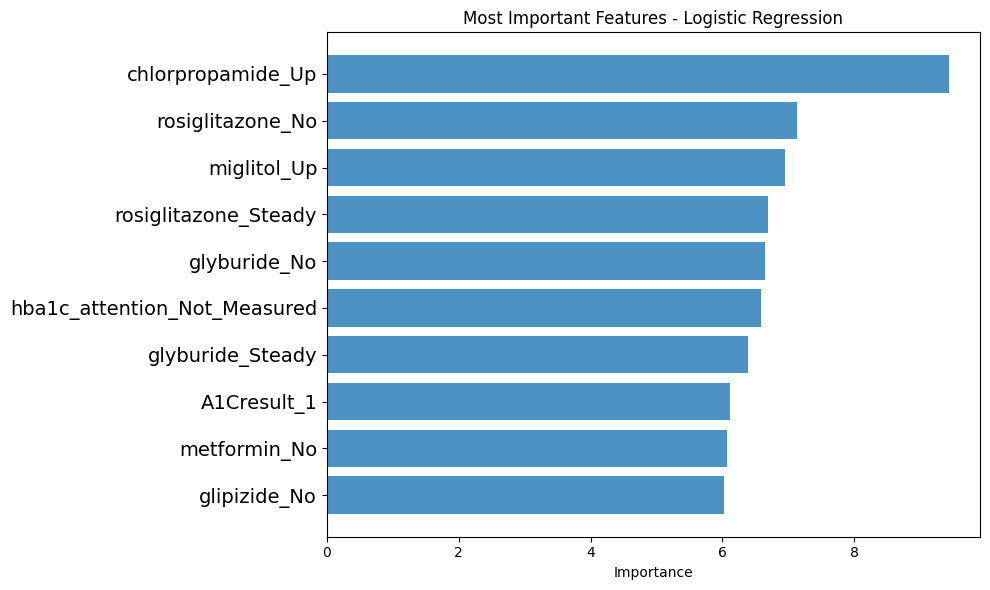


🔍 Tuning and evaluating Decision Tree...
✅ Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 5}

📊 Evaluation for Decision Tree
----------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     11230
           1       0.91      0.90      0.90     11230

    accuracy                           0.90     22460
   macro avg       0.90      0.90      0.90     22460
weighted avg       0.90      0.90      0.90     22460

Confusion Matrix:
[[10222  1008]
 [ 1178 10052]]
ROC AUC Score: 0.9120
----------------------------------------
📈 ROC Curve saved to: plots/roc_curve_decision_tree.png


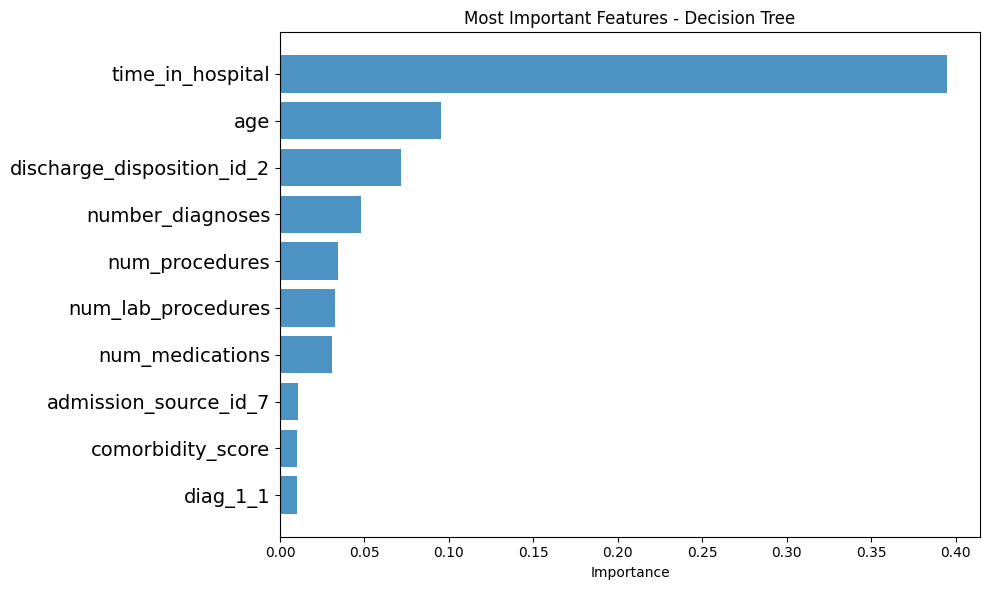


🔍 Tuning and evaluating Random Forest...
✅ Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 100}

📊 Evaluation for Random Forest
----------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     11230
           1       0.98      0.92      0.95     11230

    accuracy                           0.95     22460
   macro avg       0.96      0.95      0.95     22460
weighted avg       0.96      0.95      0.95     22460

Confusion Matrix:
[[11062   168]
 [  844 10386]]
ROC AUC Score: 0.9864
----------------------------------------
📈 ROC Curve saved to: plots/roc_curve_random_forest.png


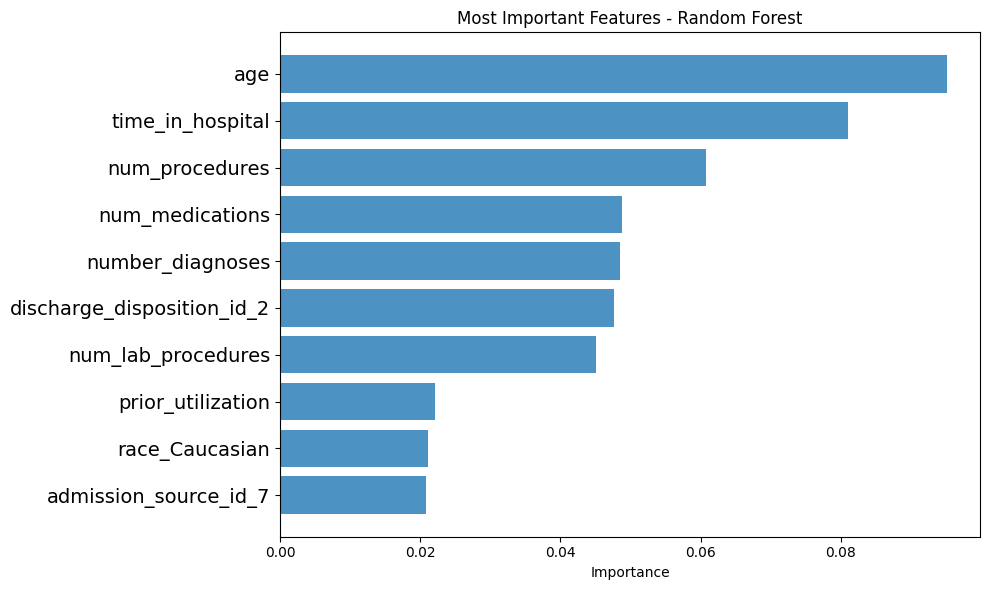


🔍 Tuning and evaluating KNN Classifier...
✅ Best parameters for KNN Classifier: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

📊 Evaluation for KNN Classifier
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     11230
           1       0.90      1.00      0.95     11230

    accuracy                           0.94     22460
   macro avg       0.95      0.94      0.94     22460
weighted avg       0.95      0.94      0.94     22460

Confusion Matrix:
[[ 9949  1281]
 [   15 11215]]
ROC AUC Score: 0.9805
----------------------------------------
📈 ROC Curve saved to: plots/roc_curve_knn_classifier.png
⚠️ KNN Classifier does not support feature importance.

🔍 Tuning and evaluating Gradient Boosting...
✅ Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

📊 Evaluation for Gradient Boosting
----------------------------------------
     

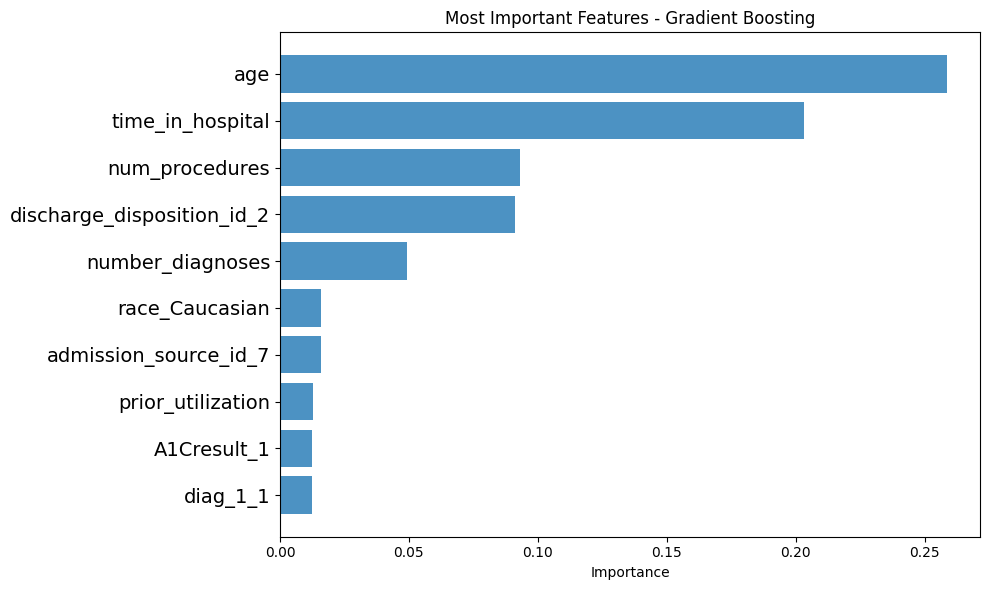


🔍 Tuning and evaluating MLP Neural Network...
✅ Best parameters for MLP Neural Network: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}

📊 Evaluation for MLP Neural Network
----------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11230
           1       0.92      0.88      0.90     11230

    accuracy                           0.91     22460
   macro avg       0.91      0.91      0.91     22460
weighted avg       0.91      0.91      0.91     22460

Confusion Matrix:
[[10423   807]
 [ 1294  9936]]
ROC AUC Score: 0.9544
----------------------------------------
📈 ROC Curve saved to: plots/roc_curve_mlp_neural_network.png
⚠️ MLP Neural Network does not support feature importance.

🔍 Tuning and evaluating XGBoost...
✅ Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

📊 Evaluation for XGBoost
-----------------------------------

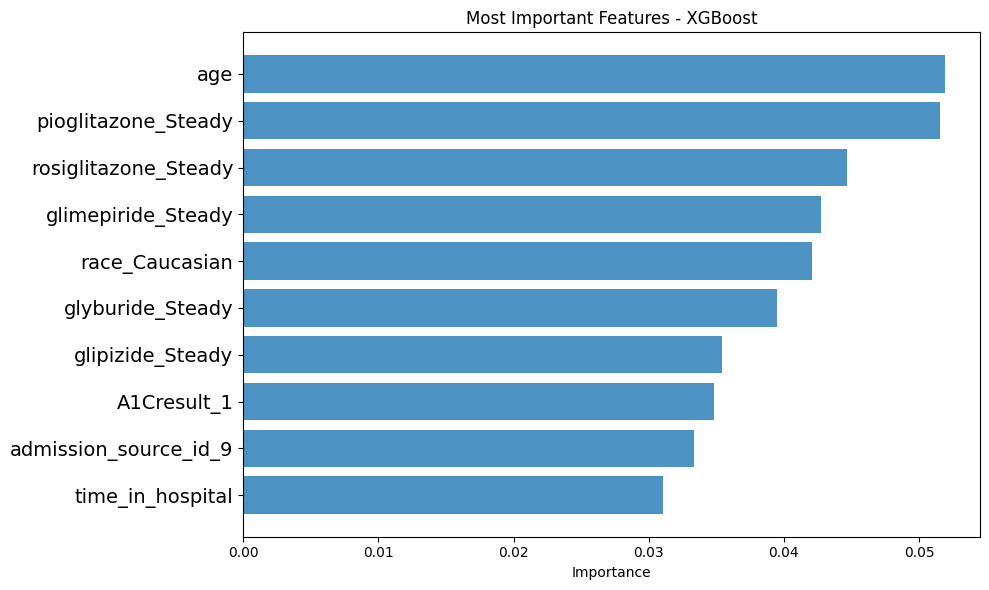


🔍 Tuning and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 44919, number of negative: 44919
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3063
[LightGBM] [Info] Number of data points in the train set: 89838, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
✅ Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 50}

📊 Evaluation for LightGBM
----------------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11230
           1       1.00      0.90      0.95     11230

    accuracy                           0.95     22460
   macro avg       0.95      0.95      0.95     22460
weighted avg       0.95   

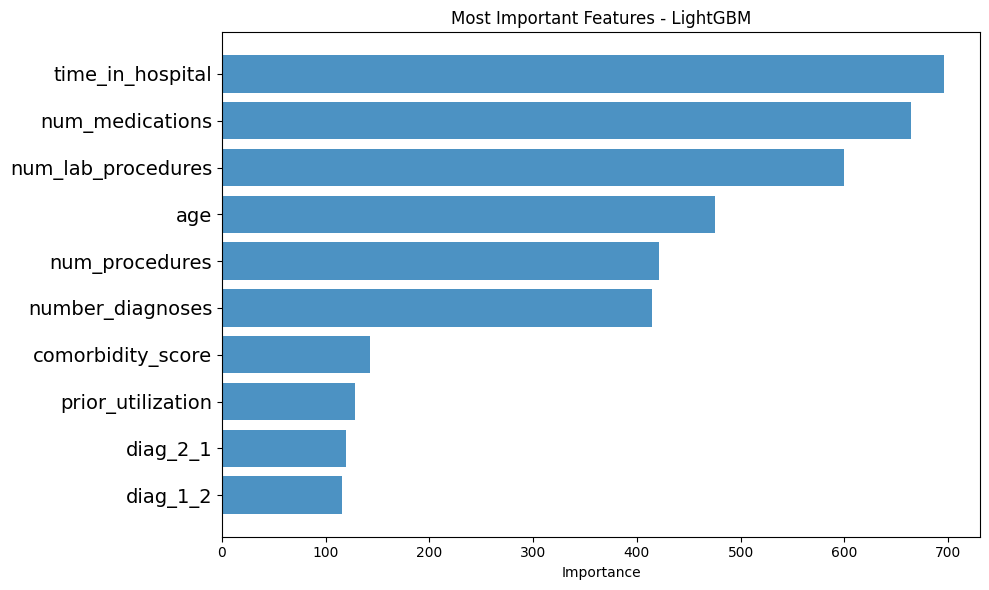

In [16]:
for name, config in models_with_params.items():
    print(f"\n🔍 Tuning and evaluating {name}...")

    # Use sanitized feature names for LightGBM and XGBoost
    X_train_fixed = sanitize_feature_names(X_train)
    X_test_fixed = sanitize_feature_names(X_test)
    grid = GridSearchCV(config["model"], config["params"], cv=3, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train_fixed, y_train)
    best_model = grid.best_estimator_
    # Save the best model using joblib
    os.makedirs("models", exist_ok=True)
    joblib.dump(best_model, f"models/{name.replace(' ', '_').lower()}_best_model.joblib")
    print(f"✅ Best parameters for {name}: {grid.best_params_}")
    # Use sanitized test set for evaluation
    evaluate_model(best_model, X_test_fixed, y_test, name)
    results[name]['best_params'] = grid.best_params_
    if hasattr(best_model, "feature_importances_"):
        plot_feature_importance(best_model, X_train_fixed.columns, f"Most Important Features - {name}")
    elif hasattr(best_model, "coef_"):
        plot_feature_importance(best_model, X_train_fixed.columns, f"Most Important Features - {name}")
    else:
        print(f"⚠️ {name} does not support feature importance.")

Plot a grouped bar chart to compare the performance metrics (Accuracy, Precision, Recall, F1 Score) of all trained models. This visualization provides a clear comparison of model strengths and weaknesses.

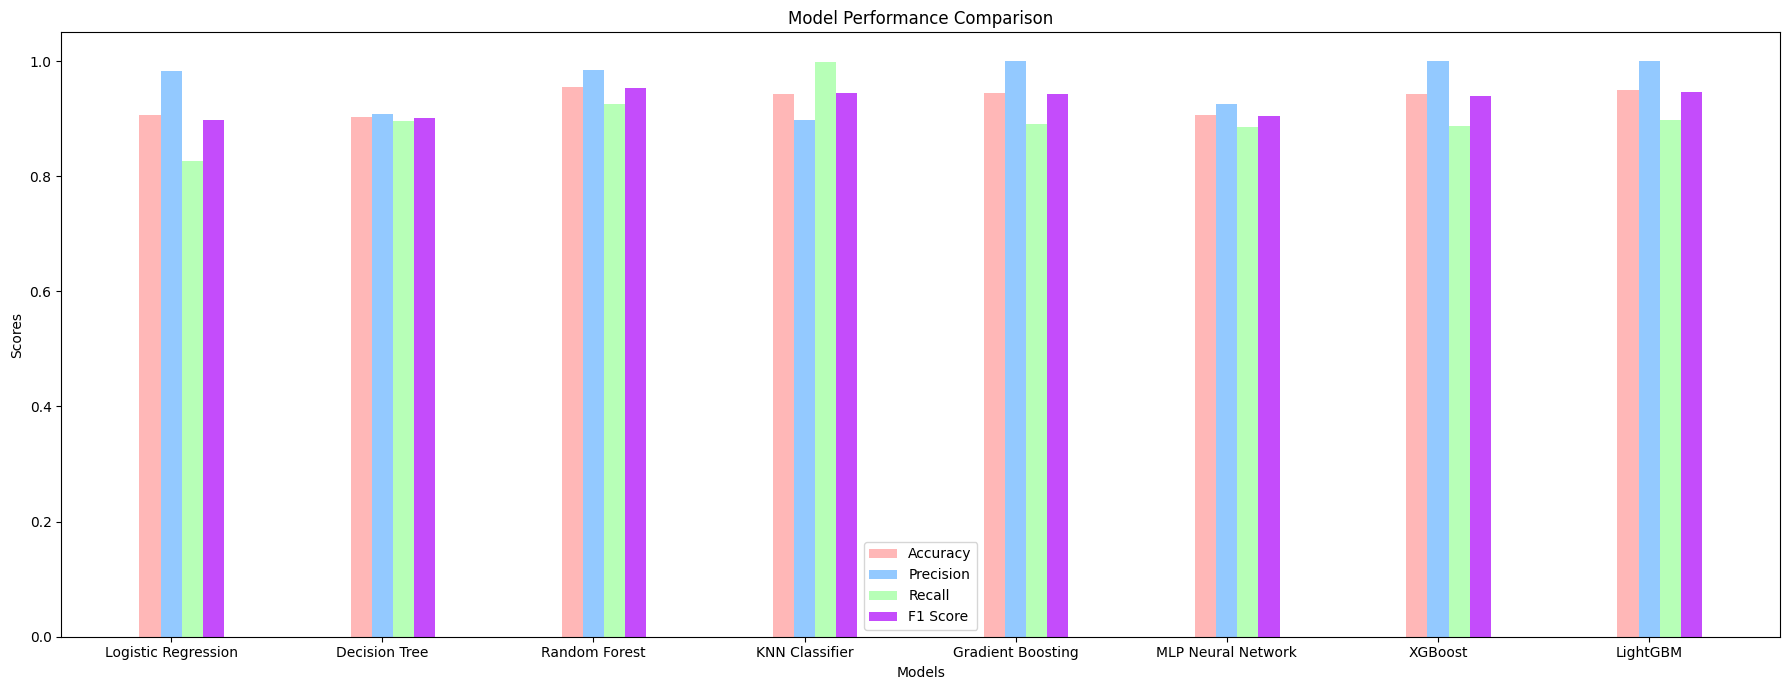

In [17]:
plt.figure(figsize=(18, 7))
x = np.arange(len(results))
width = 0.1

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
colors = ["#FF9999", "#66B3FF", "#99FF99", "#AB00FA"]

for i, (metric, color) in enumerate(zip(metrics, colors)):
    plt.bar(
        x + i * width,
        [results[model][metric] for model in results],
        width=width,
        label=metric,
        color=color,
        alpha=0.7
    )

plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Model Performance Comparison")
plt.xticks(x + width, results.keys())
plt.legend()
plt.tight_layout()
plt.show()

Identify and print the best-performing model for each metric (Accuracy, Precision, Recall, F1 Score, ROC AUC). This summary helps select the most suitable model for deployment or further analysis.

In [18]:
def get_best_model_for_each_metric(results):
    best_models = {}
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

    for metric in metrics:
        best_score = -1
        best_model_name = None
        for model_name, scores in results.items():
            if scores[metric] > best_score:
                best_score = scores[metric]
                best_model_name = model_name
        best_models[metric] = (best_model_name, best_score)
    return best_models

best_models_info = get_best_model_for_each_metric(results)

print("Best Model for Each Metric:")
for metric, (model_name, score) in best_models_info.items():
    print(f"{metric}: {model_name} ({score:.4f})")

Best Model for Each Metric:
Accuracy: Random Forest (0.9549)
Precision: Gradient Boosting (0.9999)
Recall: KNN Classifier (0.9987)
F1 Score: Random Forest (0.9535)
ROC AUC: Random Forest (0.9864)


Print the full results dictionary as formatted JSON for further inspection or reporting. This output can be used for documentation or sharing results with collaborators.

In [19]:
import json

print(json.dumps(results, indent=2, default=str))

{
  "Logistic Regression": {
    "Accuracy": 0.9061442564559217,
    "Precision": 0.9832591650773469,
    "Recall": 0.8263579697239537,
    "F1 Score": 0.898006580220631,
    "ROC AUC": 0.9431550142768899,
    "best_params": {
      "C": 10,
      "fit_intercept": true,
      "penalty": "l1"
    }
  },
  "Decision Tree": {
    "Accuracy": 0.9026714158504007,
    "Precision": 0.9088607594936708,
    "Recall": 0.8951024042742654,
    "F1 Score": 0.9019291161956035,
    "ROC AUC": 0.9119930950759201,
    "best_params": {
      "criterion": "gini",
      "max_depth": 30,
      "min_samples_split": 5
    }
  },
  "Random Forest": {
    "Accuracy": 0.9549421193232414,
    "Precision": 0.9840818646958499,
    "Recall": 0.9248441674087267,
    "F1 Score": 0.9535438854204921,
    "ROC AUC": 0.9864066166109888,
    "best_params": {
      "criterion": "gini",
      "max_depth": 25,
      "min_samples_split": 2,
      "n_estimators": 100
    }
  },
  "KNN Classifier": {
    "Accuracy": 0.942297417